# Computational Intelligence Project: Custom NN Library
## Part 1 Submission: Core Library Validation

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os
if 'lib' not in os.listdir() and os.path.exists(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib'))):
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
elif os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
from lib.network import Sequential
from lib.layers import Dense, BaseLayer
from lib.activations import Tanh
from lib.losses import MeanSquaredError
from lib.optimizer import SGD


In [85]:

# --- Gradient Check Function ---
def check_gradients(model, X, Y, epsilon=1e-7):
    """
    Compares analytical gradients (from backprop) with numerical gradients (finite difference).
    A relative error < 1e-7 confirms the backpropagation implementation is correct.
    """
    # 1. Run forward and backward pass to calculate analytical gradients (dA, db)
    Y_pred = model.forward(X)
    model.backward(Y_pred, Y)

    for idx, layer in enumerate(model.layers):
        # Only check layers with parameters (Dense)
        if not hasattr(layer, 'A'):
            continue

        print(f"\nChecking Layer {idx+1} ({layer.__class__.__name__})...")

        # --- Check Weights (A) ---
        num_grad_A = np.zeros_like(layer.A)
        it = np.nditer(layer.A, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            i = it.multi_index
            orig = layer.A[i]

            # L(W + epsilon)
            layer.A[i] = orig + epsilon
            L_plus = model.loss_function.loss(model.forward(X), Y)

            # L(W - epsilon)
            layer.A[i] = orig - epsilon
            L_minus = model.loss_function.loss(model.forward(X), Y)

            # Restore original value
            layer.A[i] = orig

            # Numerical gradient approximation
            num_grad_A[i] = (L_plus - L_minus) / (2 * epsilon)
            it.iternext()

        # --- Check Biases (b) ---
        num_grad_b = np.zeros_like(layer.b)
        it = np.nditer(layer.b, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            i = it.multi_index
            orig = layer.b[i]

            # L(b + epsilon)
            layer.b[i] = orig + epsilon
            L_plus = model.loss_function.loss(model.forward(X), Y)

            # L(b - epsilon)
            layer.b[i] = orig - epsilon
            L_minus = model.loss_function.loss(model.forward(X), Y)

            # Restore original value
            layer.b[i] = orig

            # Numerical gradient approximation
            num_grad_b[i] = (L_plus - L_minus) / (2 * epsilon)
            it.iternext()

        # Compare analytical vs numerical (Relative Error)
        # Added 1e-12 to denominator to prevent division by zero if all values are zero
        diff_A = np.linalg.norm(num_grad_A - layer.dA) / (np.linalg.norm(num_grad_A) + np.linalg.norm(layer.dA) + 1e-12)
        diff_b = np.linalg.norm(num_grad_b - layer.db) / (np.linalg.norm(num_grad_b) + np.linalg.norm(layer.db) + 1e-12)

        print(f"  Weight Gradient Diff (A): {diff_A:.10f}")
        print(f"  Bias Gradient Diff (b):   {diff_b:.10f}")

        if diff_A < 1e-7 and diff_b < 1e-7:
            print("  Status: Backprop Correct ✅")
        else:
            print("  Status: Check Gradients ⚠️ (Error too high)")

# --- Build Simple Test Network for Gradient Check (2-2-1) ---
grad_check_model = Sequential()
grad_check_model.add(Dense(input_size=2, output_size=2, init_scale=0.1))
grad_check_model.add(Tanh())
grad_check_model.add(Dense(input_size=2, output_size=1, init_scale=0.1))
grad_check_model.add(Tanh())
grad_check_model.compile(optimizer=SGD(learning_rate=0.01), loss_function=MeanSquaredError())

# --- Run Gradient Check ---
# Using a single sample for simplicity
X_check = np.array([[-1.0], [0.5]]) 
Y_check = np.array([[-1.0]])       

print("Starting Gradient Check on Test Network...")
check_gradients(grad_check_model, X_check, Y_check)

# Data in (Features x Samples) format
X_xor = np.array([[-1, -1, 1, 1], [-1, 1, -1, 1]], dtype=np.float32) # (2, 4)
Y_xor = np.array([[-1, 1, 1, -1]], dtype=np.float32)                 # (1, 4)

# Build XOR Network (2 inputs -> 4 hidden -> 1 output)
xor_check_model = Sequential()
xor_check_model.add(Dense(input_size=2, output_size=4, init_scale=0.01))
xor_check_model.add(Tanh())
xor_check_model.add(Dense(input_size=4, output_size=1, init_scale=0.01))
xor_check_model.add(Tanh())
xor_check_model.compile(optimizer=SGD(learning_rate=0.001), loss_function=MeanSquaredError()) 

print("\n\nStarting Gradient Check on XOR Network (2-4-1 Tanh)...")
check_gradients(xor_check_model, X_xor[:, [0]], Y_xor[:, [0]])



Starting Gradient Check on Test Network...

Checking Layer 1 (Dense)...
  Weight Gradient Diff (A): 0.0000000025
  Bias Gradient Diff (b):   0.0000000010
  Status: Backprop Correct ✅

Checking Layer 3 (Dense)...
  Weight Gradient Diff (A): 0.0000000084
  Bias Gradient Diff (b):   0.0000000004
  Status: Backprop Correct ✅


Starting Gradient Check on XOR Network (2-4-1 Tanh)...

Checking Layer 1 (Dense)...
  Weight Gradient Diff (A): 0.0000000119
  Bias Gradient Diff (b):   0.0000000119
  Status: Backprop Correct ✅

Checking Layer 3 (Dense)...
  Weight Gradient Diff (A): 0.0000000170
  Bias Gradient Diff (b):   0.0000000001
  Status: Backprop Correct ✅


Epoch 100/10000 - Loss: 0.500014
Epoch 200/10000 - Loss: 0.500013
Epoch 300/10000 - Loss: 0.500012
Epoch 400/10000 - Loss: 0.500011
Epoch 500/10000 - Loss: 0.500010
Epoch 600/10000 - Loss: 0.500009
Epoch 700/10000 - Loss: 0.500008
Epoch 800/10000 - Loss: 0.500007
Epoch 900/10000 - Loss: 0.500006
Epoch 1000/10000 - Loss: 0.500005
Epoch 1100/10000 - Loss: 0.500004
Epoch 1200/10000 - Loss: 0.500003
Epoch 1300/10000 - Loss: 0.500002
Epoch 1400/10000 - Loss: 0.500002
Epoch 1500/10000 - Loss: 0.500001
Epoch 1600/10000 - Loss: 0.500000
Epoch 1700/10000 - Loss: 0.499999
Epoch 1800/10000 - Loss: 0.499999
Epoch 1900/10000 - Loss: 0.499998
Epoch 2000/10000 - Loss: 0.499997
Epoch 2100/10000 - Loss: 0.499996
Epoch 2200/10000 - Loss: 0.499996
Epoch 2300/10000 - Loss: 0.499995
Epoch 2400/10000 - Loss: 0.499994
Epoch 2500/10000 - Loss: 0.499994
Epoch 2600/10000 - Loss: 0.499993
Epoch 2700/10000 - Loss: 0.499992
Epoch 2800/10000 - Loss: 0.499992
Epoch 2900/10000 - Loss: 0.499991
Epoch 3000/10000 - Loss

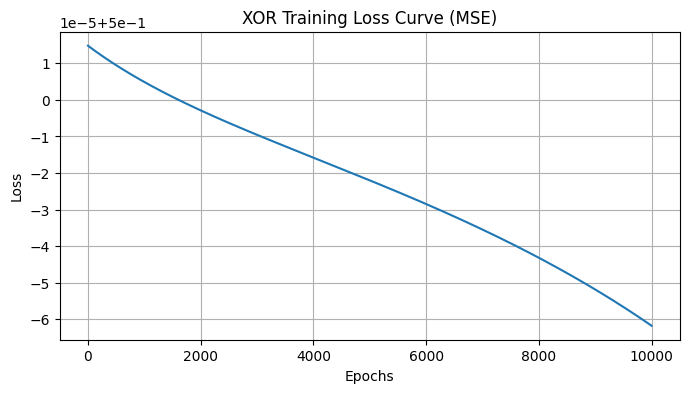

In [ ]:
#XOR Dataset
X_xor = np.array([[-1, -1,  1,  1],
                  [-1,  1, -1,  1]])

Y_xor = np.array([[-1,  1,  1, -1]]) 

#network
xor_model = Sequential()
xor_model.add(Dense(input_size=2, output_size=4, init_scale=0.1))
xor_model.add(Tanh())
xor_model.add(Dense(input_size=4, output_size=1, init_scale=0.1))
xor_model.add(Tanh())

#Hyperparameters
LR = 0.5
EPOCHS = 10000
xor_model.compile(optimizer=SGD(learning_rate=LR), loss_function=MeanSquaredError())



loss_history = xor_model.train(X_xor, Y_xor, epochs=EPOCHS)
Y_pred_raw = xor_model.predict(X_xor)
Y_pred_class = np.where(Y_pred_raw >= 0, 1, -1)


# --- Display Results ---
print("\nFinal XOR Predictions:")
print("------------------------")
print("Input (X):\n", X_xor.T)
print("Target (Y):\n", Y_xor.T)
print("\nRaw Prediction (Tanh Output):\n", Y_pred_raw.T)
print("Classified Prediction:\n", Y_pred_class.T)
print(f"\nFinal Loss: {loss_history[-1]:.6f}")


# --- Plot Loss Curve ---
plt.figure(figsize=(8,4))
plt.plot(loss_history)
plt.title("XOR Training Loss Curve (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Final XOR Predictions:
------------------------
Input (X):
 [[-1. -1.  1.  1.]
 [-1.  1. -1.  1.]]
Target (Y):
 [[-1.  1.  1. -1.]]

Raw Prediction (Tanh Output):
 [[-0.89895016  0.894566    0.8943093  -0.89986396]]
Classified Prediction:
 [[-1  1  1 -1]]

Final Loss: 0.010633


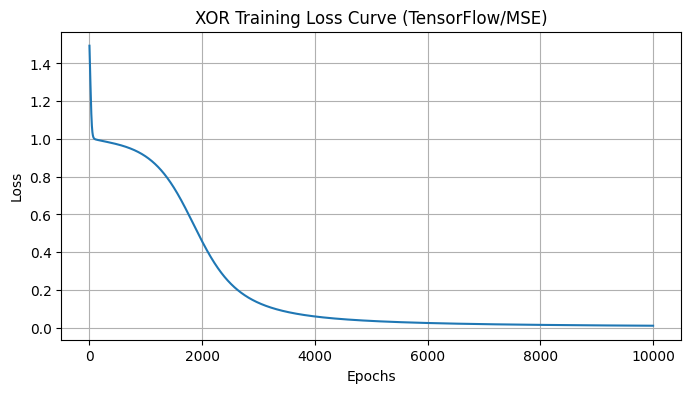

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
##XOR Dataset
X_xor = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]], dtype=np.float32)
Y_xor = np.array([[-1], [1], [1], [-1]], dtype=np.float32)




#network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, input_dim=2, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='tanh')
])

#Hyperparameters
LR = 0.01
EPOCHS = 10000

optimizer = tf.keras.optimizers.SGD(learning_rate=LR)
model.compile(optimizer=optimizer, loss='mean_squared_error')





history = model.fit(X_xor, Y_xor, epochs=EPOCHS, verbose=0)
loss_history = history.history['loss']
Y_pred_raw = model.predict(X_xor)
Y_pred_class = np.where(Y_pred_raw >= 0, 1, -1)


# --- Display Results ---
print("\nFinal XOR Predictions:")
print("------------------------")
print("Input (X):\n", X_xor.T)
print("Target (Y):\n", Y_xor.T)
print("\nRaw Prediction (Tanh Output):\n", Y_pred_raw.T)
print("Classified Prediction:\n", Y_pred_class.T)
print(f"\nFinal Loss: {loss_history[-1]:.6f}")

# --- Plot Loss Curve ---
plt.figure(figsize=(8,4))
plt.plot(loss_history)
plt.title("XOR Training Loss Curve (TensorFlow/MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
